In [1]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy

# personal libraries
import helpers as helpers

In [2]:
# Load Trajectory
fname = "LJ7_traj.npz"
inData = np.load(fname)
data = inData["data"]
print(f"Shape of trajectory data:{data.shape}")
N = data.shape[1]
print(f"Number of data points:{N}")

# Load Diffusions
fname = "LJ7_traj_diffusions.npz"
inData = np.load(fname)
diffusions = inData["diffusions"]
print(f"Shape of diffusion data:{diffusions.shape}")


# Load Free Energy
fname = "LJ7_free_energy_grid.npz"
inData = np.load(fname)
free_energy = inData["free_energy"]
nx = inData["nx"]
ny = inData["ny"]
xmin = inData["xmin"]
xmax = inData["xmax"]
ymin = inData["ymin"]
ymax = inData["ymax"]
print(f"Shape of free energy data:{free_energy.shape}")
print(f"nx:{nx}")
print(f"ny:{ny}")
print(f"xmin:{xmin}")
print(f"xmax:{xmax}")
print(f"ymin:{ymin}")
print(f"ymax:{ymax}")

Shape of trajectory data:(2, 10000)
Number of data points:10000
Shape of diffusion data:(10000, 2, 2)
Shape of free energy data:(401, 201)
nx:201
ny:401
xmin:0.2
xmax:1.2
ymin:-0.5
ymax:1.7


(-0.5, 1.7)

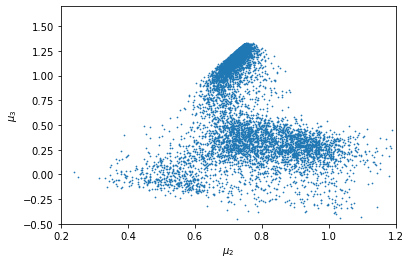

In [3]:
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.5)
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])


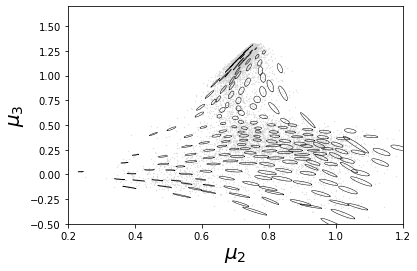

In [4]:
# Cluster data points for better visualization
n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters, random_state=10).fit(data.T)
    
# Plot sampling of diffusion tensors
fig = plt.figure() 
plt.scatter(data[0, :], data[1, :], s=0.1, c='lightgray')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$\mu_2$', size=20)
plt.ylabel(r'$\mu_3$', size=20)
for i in range(n_clusters):
    idx = np.argmin(np.sum((data.T - kmeans.cluster_centers_[i,:])**2,axis=1))
    C = diffusions[idx, :, :]
    helpers.plot_cov_ellipse(C, data[:, idx], plot_scale=0.01)
plt.show()


Text(0, 0.5, '$\\mu_3$')

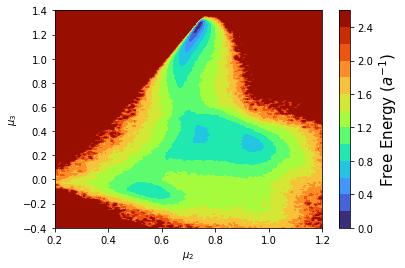

In [5]:
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
xx, yy = np.meshgrid(x, y)

plt.figure()
plt.contourf(xx, yy, free_energy, levels=15, cmap='turbo')
#plt.scatter(data[0, :], data[1, :], s=1, c='k')

cbar = plt.colorbar()
cbar.set_label(r'Free Energy ($a^{-1}$)', size=15)
plt.xlim([0.2, 1.2])
plt.ylim([-0.4, 1.4])
plt.xlabel(r'$\mu_2$')
plt.ylabel(r'$\mu_3$')

16444
30300
400
514


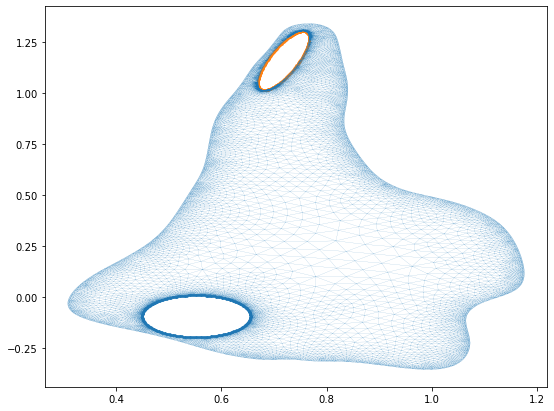

In [6]:
# download triangular mesh
pts = np.loadtxt('LJ7_pts_ABellipses.csv', delimiter=',', dtype=float)
tri = np.loadtxt('LJ7_tri_ABellipses.csv', delimiter=',', dtype=int)
Npts = np.size(pts,axis = 0)
Ntri = np.size(tri,axis = 0)
print(Npts)
print(Ntri)
# download indices of mesh points at the boundaries of A and B
Aind = np.loadtxt('LJ7_Abdry_ABellipses.csv', delimiter=',', dtype=int) # find mesh points on \partial A
NAind = np.size(Aind)
print(NAind)
Bind = np.loadtxt('LJ7_Bbdry_ABellipses.csv', delimiter=',', dtype=int)  # find mesh points on \partial B
NBind = np.size(Bind)
print(NBind)

fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
plt.scatter(pts[Aind,0],pts[Aind,1],s = 2)
plt.scatter(pts[Bind,0],pts[Bind,1],s = 2)
plt.savefig('LJ72D_trimesh_ABellipses.pdf')


In [7]:
print(pts.shape)

(16444, 2)


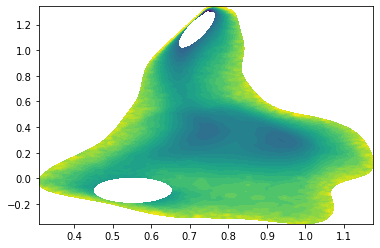

In [8]:
# interpolate the free enegry from the regular grid onto the mesh points
FE = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(free_energy)) #, method = "linear",bounds_error=False, fill_value = 1.8)
Fpts = FE(pts)
plt.tricontourf(pts[:,0], pts[:,1],tri,Fpts,np.arange(0.2,1.8,0.05) )

In [9]:
with open('LJ7_ABellipses_free.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(Fpts[:,None])

In [10]:
# interpolate entries of the diffusion matrix onto the mesh points
print(np.shape(data))
print(np.shape(diffusions[:,0,0]))
# data are the trajectory data
# (xx,yy) - meshgrid points
M11grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,0,0],(xx,yy),method = 'linear')
M12grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,0,1],(xx,yy),method = 'linear')
M22grid = scipy.interpolate.griddata(np.transpose(data),diffusions[:,1,1],(xx,yy),method = 'linear')

(2, 10000)
(10000,)


0  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values
1085  points with nan or inf values
1085  points with nan or inf values
1085  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values
0  points with nan or inf values


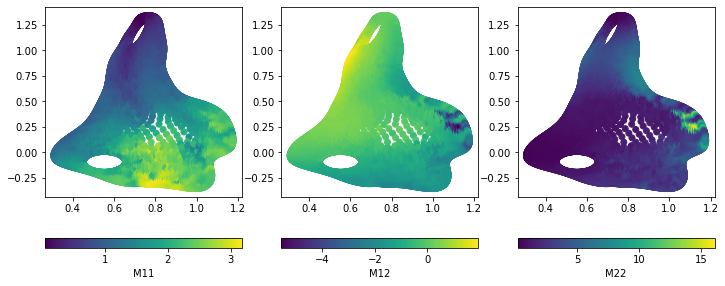

In [11]:
def check_inf_nan(arr):
    ind_bad = np.argwhere(np.isnan(arr))
    print(np.size(ind_bad)," points with nan or inf values")
    return ind_bad

ind_bad = check_inf_nan(diffusions[:,0,0])
ind_bad = check_inf_nan(diffusions[:,0,1])
ind_bad = check_inf_nan(diffusions[:,1,1])

# Mijgrid are matrix enties linearly interpolated onto regular grid
# create linear interpolator functions
M11fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M11grid))
M12fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M12grid))
M22fun = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(M22grid))
# evaluate linear interpolator functions at the FEM mesh points
M11pts = M11fun(pts)
M12pts = M12fun(pts)
M22pts = M22fun(pts)

# at some points, the linear interpolator fails
# We create a nearest neighbor interpolator for these bad points
ind_bad = check_inf_nan(M11pts)
M11fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,0,0])
M11pts[ind_bad] = M11fun_NN(pts[ind_bad,:])

ind_bad = check_inf_nan(M12pts)
M12fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,0,1])
M12pts[ind_bad] = M12fun_NN(pts[ind_bad,:])

ind_bad = check_inf_nan(M22pts)
M22fun_NN = scipy.interpolate.NearestNDInterpolator(np.transpose(data), diffusions[:,1,1])
M22pts[ind_bad] = M22fun_NN(pts[ind_bad,:])

fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.subplot(1,3,1)
plt.scatter(pts[:,0], pts[:,1],c = M11pts)
plt.colorbar(label="M11", orientation="horizontal")
ind_bad = check_inf_nan(M11pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.subplot(1,3,2)
plt.scatter(pts[:,0], pts[:,1],c = M12pts)
plt.colorbar(label="M12", orientation="horizontal")
ind_bad = check_inf_nan(M12pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.subplot(1,3,3)
plt.scatter(pts[:,0], pts[:,1],c = M22pts)
plt.colorbar(label="M22", orientation="horizontal")
ind_bad = check_inf_nan(M22pts)
plt.scatter(pts[ind_bad,0], pts[ind_bad,1],s = 0.1)
plt.savefig('LJ72D_Mmatrix.pdf')


In [12]:
# find the committor
beta = 5
# q = FEM_committor_solver(pts,tri,Aind,Bind,Fpts,M11pts,M12pts,M22pts,beta)

In [13]:
# q = q[:,None]
# with open('LJ7_ABellipses_q.csv', 'w', newline='') as file:
#     mywriter = csv.writer(file, delimiter=',')
#     mywriter.writerows(q)
q = np.loadtxt('LJ7_ABellipses_q.csv', delimiter=',')

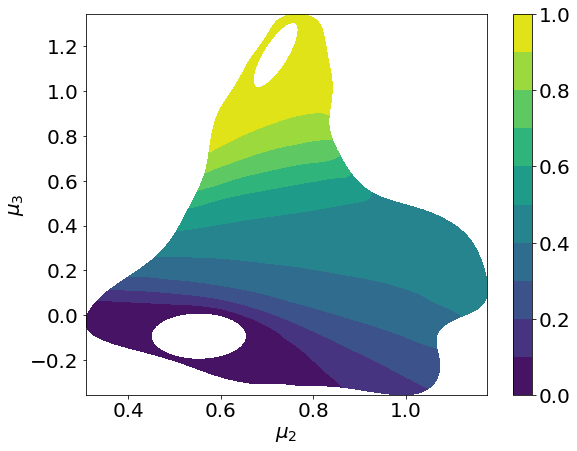

In [16]:
# visualize the committor
fig = plt.gcf()
fig.set_size_inches(9, 7)
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
# plt.colorbar(orientation="vertical")
plt.xlabel('$\mu_2$',fontsize=20)
plt.ylabel('$\mu_3$',fontsize=20)
# axes=plt.gca()
# axes.set_aspect(1)
plt.colorbar()
plt.rcParams.update({'font.size': 20})
plt.savefig('LJ72D_committor_ABellipses.pdf')

count =  200 displacement =  0.00892968883362114
count =  400 displacement =  0.00459190473183766
Npts =  207  Ntri =  369
Npts =  113  Ntri =  173
Z =  0.005201968521730466


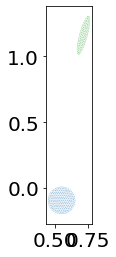

In [14]:
xa = 0.5526
ya = -0.0935
xb = 0.7184
yb = 1.1607
theta = 5*np.pi/12
rx = 0.15
ry = 0.03
ra = 0.103
h0 = 0.015
Na = int(np.round(2*np.pi*ra/h0)) # the number of points on the A-circle
# Nb = int(np.round(2*np.pi*rb/h0)) # the number of points on the B-circle
         
ptsA = put_pts_on_circle(xa,ya,ra,Na) 
ptsB = put_pts_on_ellipses(xb,yb,rx,ry,theta,Na)

def dfuncA(p):
    return dcircle(p,xa,ya,ra)

def dfuncB(p):
    return dellipse(p,xb,yb,rx,ry,theta)

bbox = [xa-ra,xa+ra,ya-ra,ya+ra]
pts_Amesh,tri_Amesh = distmesh2D(dfuncA,huniform,h0,bbox,ptsA)
bbox = [xb-rx,xb+rx,yb-rx,yb+rx]
pts_Bmesh,tri_Bmesh = distmesh2D(dfuncB,huniform,h0,bbox,ptsB)

Npts_Amesh = np.size(pts_Amesh,axis=0)
Ntri_Amesh = np.size(tri_Amesh,axis=0)
print("Npts = ",Npts_Amesh," Ntri = ",Ntri_Amesh) 

Npts_Bmesh = np.size(pts_Bmesh,axis=0)
Ntri_Bmesh = np.size(tri_Bmesh,axis=0)
print("Npts = ",Npts_Bmesh," Ntri = ",Ntri_Bmesh) 

FE = scipy.interpolate.RegularGridInterpolator((x,y),np.transpose(free_energy)) #, method = "linear",bounds_error=False, fill_value = 1.8)
Fpts_A = FE(pts_Amesh)
Fpts_B = FE(pts_Bmesh)
                         
Z = invariant_pdf(pts,tri,pts_Amesh,tri_Amesh,pts_Bmesh,tri_Bmesh,Fpts,Fpts_A,Fpts_B,beta)
print("Z = ",Z)

In [15]:
print(Fpts.shape)
print(Fpts_A.shape)
print(tri.shape)

(16444,)
(207,)
(30300, 3)


In [16]:
with open('LJ7_Apts.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(pts_Amesh)
with open('LJ7_Bpts.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(pts_Bmesh)
with open('LJ7_Atri.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(tri_Amesh)
with open('LJ7_Btri.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(tri_Bmesh)
with open('M11.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(M11pts[:,None])
with open('M12.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(M12pts[:,None])
with open('M22.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(M22pts[:,None])
with open('Fpts_A.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(Fpts_A[:,None])
with open('Fpts_B.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(Fpts_B[:,None])

In [17]:
print(M11pts.shape)

(16444,)


In [18]:
Rcurrent, Rrate = reactive_current_and_transition_rate_updated(pts,tri,Fpts,M11pts,M12pts,M22pts,beta,q,Z)
print('transition rate: ', Rrate)


transition rate:  0.09275891374079584


In [19]:
rho_AB = probability_reactive(pts,tri,Fpts,beta,q,Z)
print('rho_AB is: ', rho_AB)

rho_AB is:  0.11611859460573026


In [22]:
rho_A = probability_last_A(pts,tri,pts_Amesh,tri_Amesh,Fpts,Fpts_A,beta,q,Z)
print(rho_A)

0.34883642267006415
